In [14]:
data_1 = './spring-1.tsv'
data_2 = './spring-2.tsv'


--- Bearbeite Datei: ./spring-1.tsv ---
Lese Daten aus: ./spring-1.tsv

--- Bearbeite Datei: ./spring-2.tsv ---
Lese Daten aus: ./spring-2.tsv

Erstelle vergleichendes Diagramm...


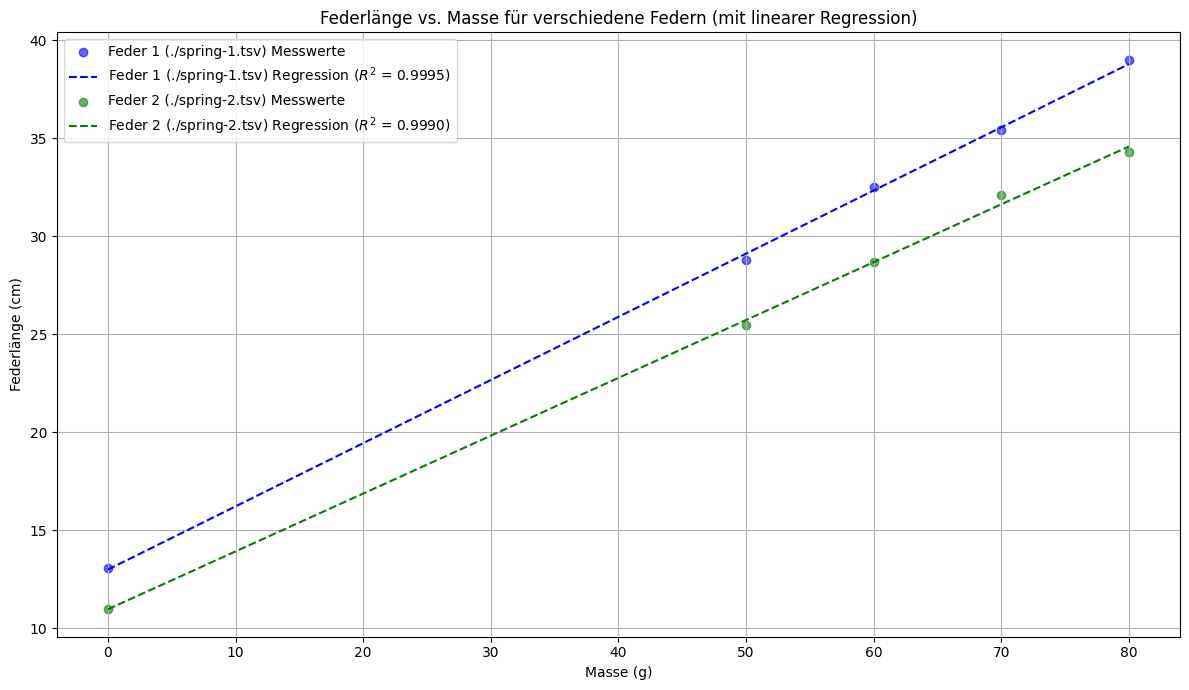

Diagramm erfolgreich angezeigt.

Speichere Ergebnisse unter: parameters.txt
Alle Ergebnisse erfolgreich gespeichert.

Skript beendet.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- Konfigurationsparameter ---
# Namen deiner TSV-Dateien
# WICHTIG: Dateinamen müssen als Strings übergeben werden!
TSV_FILE_NAMES = [data_1, data_2] # Beispiel: Passe diese an deine tatsächlichen Dateinamen an
OUTPUT_RESULTS_NAME = 'parameters.txt' # Dateiname für die Ergebnisdatei
GRAVITY_ACCELERATION_G = 9.81 # Erdbeschleunigung in m/s^2

# --- 1. Funktion zum Lesen der Daten ---
def read_spring_data(file_path):
    """
    Liest Massen- und Längendaten aus einer TSV-Datei.
    Erwartet zwei Spalten, z.B. 'Masse_g' und 'Laenge_cm'.
    Gibt ein Pandas DataFrame zurück oder None bei Fehler.
    """
    print(f"Lese Daten aus: {file_path}")
    try:
        df = pd.read_csv(file_path, sep='\t')
        return df
    except FileNotFoundError:
        print(f"Fehler: Datei '{file_path}' nicht gefunden. Bitte stelle sicher, dass die Datei im selben Verzeichnis wie das Skript liegt.")
        return None
    except Exception as e:
        print(f"Ein Fehler ist beim Lesen der Datei aufgetreten: {e}")
        return None

# --- 2. Funktion zur Analyse und Berechnung ---
# Aktualisiert: Gibt std_err der Steigung zurück
def analyze_spring_data(mass_g, length_cm, g_accel=GRAVITY_ACCELERATION_G):
    """
    Führt eine lineare Regression durch, um die Federkonstante und die Ruhelänge zu bestimmen.
    Gibt k (N/m), L0 (m), Steigung, Y-Achsenabschnitt, R-Quadrat und die Standardabweichung der Steigung zurück.
    """
    mass_kg = mass_g / 1000 # Gramm zu Kilogramm
    length_m = length_cm / 100 # Zentimeter zu Meter

    # Lineare Regression: Länge_m = Anstieg * Masse_kg + Y-Achsenabschnitt
    slope, intercept, r_value, p_value, std_err = linregress(mass_kg, length_m)

    # Berechnung der Federkonstante (k = g / Anstieg)
    if slope == 0:
        print("Warnung: Der Anstieg der Regressionsgeraden ist Null. Federkonstante kann nicht berechnet werden.")
        spring_constant_Nm = float('nan')
        uncertainty_k_Nm = float('nan') # Unsicherheit ist auch NaN, wenn k NaN ist
    else:
        spring_constant_Nm = g_accel / slope
        # Berechnung der Unsicherheit der Federkonstante
        # sigma_k = (g / slope^2) * std_err
        uncertainty_k_Nm = (g_accel / (slope**2)) * std_err

    rest_length_m = intercept # Die Ruhelänge ist der Y-Achsenabschnitt

    # Rückgabe von std_err für die Steigung
    return spring_constant_Nm, uncertainty_k_Nm, rest_length_m, slope, intercept, r_value**2, std_err

# --- 3. Funktion zum Erstellen des Diagramms für mehrere Federn ---
def plot_multiple_spring_data(spring_data_for_plot):
    """
    Erstellt ein Streudiagramm für mehrere Federn und plottet deren Regressionsgeraden.
    Zeigt das Diagramm direkt im Notebook an.
    """
    print("\nErstelle vergleichendes Diagramm...")
    plt.figure(figsize=(12, 7))

    colors = ['blue', 'green', 'orange', 'purple', 'red', 'cyan', 'magenta', 'yellow'] # Farben für verschiedene Federn

    for i, spring_info in enumerate(spring_data_for_plot):
        mass_g = spring_info['mass_g']
        length_cm = spring_info['length_cm']
        slope = spring_info['slope']
        intercept = spring_info['intercept']
        r_squared = spring_info['r_squared']
        label = spring_info['label']
        color = colors[i % len(colors)] # Wählt eine Farbe aus der Liste

        # Streudiagramm der Originaldaten
        plt.scatter(mass_g, length_cm, color=color, alpha=0.6, label=f'{label} Messwerte')

        # Regressionsgerade
        # Die Regressionsgerade wird mit den ursprünglichen Einheiten (g und cm) geplottet.
        mass_g_plot = np.array([mass_g.min(), mass_g.max()])
        predicted_length_m = slope * (mass_g_plot / 1000) + intercept
        predicted_length_cm = predicted_length_m * 100
        plt.plot(mass_g_plot, predicted_length_cm, color=color, linestyle='--',
                 label=f'{label} Regression ($R^2$ = {r_squared:.4f})')

    plt.title('Federlänge vs. Masse für verschiedene Federn (mit linearer Regression)')
    plt.xlabel('Masse (g)')
    plt.ylabel('Federlänge (cm)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show() # Zeigt das Diagramm direkt im Notebook an
    print("Diagramm erfolgreich angezeigt.")

# --- 4. Funktion zum Speichern der Ergebnisse mehrerer Federn ---
# Aktualisiert: Speichert auch die Unsicherheit von k
def save_multiple_results(all_results, output_file=OUTPUT_RESULTS_NAME):
    """
    Speichert die berechneten Federparameter für alle Federn in einer einzigen Textdatei.
    """
    print(f"\nSpeichere Ergebnisse unter: {output_file}")
    with open(output_file, 'w') as f:
        f.write(f"--- Federanalyse-Ergebnisse für {len(all_results)} Federn ---\n\n")
        for i, res in enumerate(all_results):
            f.write(f"=== Ergebnisse für Feder {i+1}: {res['label']} ===\n")
            f.write(f"Federkonstante (k): {res['spring_constant']:.4f} N/m +/- {res['uncertainty_k']:.4f} N/m\n")
            f.write(f"Ruhelänge (L0): {res['rest_length']:.4f} m ({res['rest_length'] * 100:.2f} cm)\n")
            f.write(f"-----------------------------------------\n\n")
    print("Alle Ergebnisse erfolgreich gespeichert.")

# --- Hauptausführung im Notebook ---
if __name__ == "__main__":
    all_spring_results = [] # Liste zum Speichern der Analyseergebnisse
    all_spring_plot_data = [] # Liste zum Speichern der Daten für das Diagramm

    for i, file_name in enumerate(TSV_FILE_NAMES):
        print(f"\n--- Bearbeite Datei: {file_name} ---")
        data = read_spring_data(file_name)

        if data is not None:
            # Überprüfen, ob das DataFrame leer ist
            if data.empty:
                print(f"Warnung: Datei '{file_name}' ist leer oder enthält keine Daten. Überspringe Analyse.")
                continue

            # Sicherstellen, dass die Spalten die erwarteten Daten enthalten und numerisch sind
            if data.shape[1] < 2:
                print(f"Fehler: Datei '{file_name}' hat nicht genügend Spalten. Erwartet 2 Spalten.")
                continue

            # Annahme: Erste Spalte ist Masse, zweite ist Länge
            masses = pd.to_numeric(data.iloc[:,0], errors='coerce')
            lengths = pd.to_numeric(data.iloc[:,1], errors='coerce')

            # Entferne NaN-Werte, falls durch coerce entstanden
            combined_data = pd.DataFrame({'masses': masses, 'lengths': lengths}).dropna()
            if combined_data.empty:
                print(f"Fehler: Keine gültigen numerischen Daten in '{file_name}' nach Bereinigung. Überspringe Analyse.")
                continue

            masses = combined_data['masses']
            lengths = combined_data['lengths']

            # Aktualisierter Aufruf der Analysefunktion
            k_val, uncertainty_k_val, l0_val, reg_slope, reg_intercept, r_sq, slope_std_err = analyze_spring_data(masses, lengths)

            if not np.isnan(k_val):
                spring_label = f"Feder {i+1} ({file_name})"
                all_spring_results.append({
                    'label': spring_label,
                    'spring_constant': k_val,
                    'uncertainty_k': uncertainty_k_val, # Neu hinzugefügt
                    'rest_length': l0_val
                })
                all_spring_plot_data.append({
                    'label': spring_label,
                    'mass_g': masses,
                    'length_cm': lengths,
                    'slope': reg_slope,
                    'intercept': reg_intercept,
                    'r_squared': r_sq
                })
            else:
                print(f"Analyse für '{file_name}' konnte aufgrund eines Null-Anstiegs nicht abgeschlossen werden.")
        else:
            print(f"Überspringe Analyse für '{file_name}' aufgrund von Lesefehlern.")

    # Schritt 3: Diagramm erstellen (wenn Daten vorhanden sind)
    if all_spring_plot_data:
        plot_multiple_spring_data(all_spring_plot_data)
    else:
        print("\nKeine Daten zum Plotten verfügbar.")

    # Schritt 4: Ergebnisse speichern (wenn Daten vorhanden sind)
    if all_spring_results:
        save_multiple_results(all_spring_results)
    else:
        print("\nKeine Ergebnisse zum Speichern verfügbar.")

    print("\nSkript beendet.")